# Installation
CNGI documentation is located here:
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide


In [1]:
import os

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install cngi-prototype==0.0.36")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


# Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only.

In [0]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

# Convert an MS to xarray/zarr
CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format to hold the contents of the MS.

The zarr format is a directory structure with partitions and chunks held under the top level folder. The MS data will be partitioned by the Data Description ID (DDI) column.  A DDI is a unique SPW/Polarization pair so the data has a fixed shape within each DDI (but potentially different shapes across DDIs).  

Various index columns are converted to xarray coordinates rather than data variables.  Polarization and Spectral Window table data pertaining to each DDI is held in the coordinates and attributes section.

Remaining tables (other than the main visibilities, spw and polarization) are held in a global partition of all other meta data.

In [2]:
from cngi.conversion import convert_ms

convert_ms('sis14_twhya_calibrated_flagged.ms');

processing sis14_twhya_calibrated_flagged.ms 
writing global partition
meta data processing time  0.6430296897888184
**********************************
Processing ddi 0
Selecting and sorting time  0.026243925094604492
n_time: 410   n_baseline: 210   n_chan: 384   n_pol: 2  chunking:  [100, 400, 20, 1]  batchsize:  100
Completed ddi 0  process time  18.636914491653442
**********************************


In our example, there is one DDI (0), so the resulting visibilities zarr directory has one partition plus the global data

In [3]:
!ls sis14_twhya_calibrated_flagged.vis.zarr/

0  global


# Open and Inspect Visibility Data

Each SPW in the visiblity data must go in to its own xarray dataset. 

Before trying to open something, we can use the describe_vis function to see what's what in the zarr directory.


In [4]:
from cngi.dio import describe_vis

describe_vis('sis14_twhya_calibrated_flagged.vis.zarr')

,spw_id,size_GB,channels,times,baselines,fields
ddi,,,,,,
0,0,1.053953,384,410,210,410


If multiple DDI partitions exist, then each one would need to be read individually.  In our example, there is only DDI 0, so we will read that one.

In [0]:
from cngi.dio import read_vis

# returns an xarray dataset representation of the specified zarr directory partition
vis_xds = read_vis('sis14_twhya_calibrated_flagged.vis.zarr', ddi=0)

Within the xarray dataset visibility structure, we find the old column names from the MS main table spread between several locations

Most of the main table columns are stored in the **Data variables** section, while the **Coordinates** section holds what used to be id and index columns. The **Dimensions** section holds the size of the visibility data axes as determined by the coordinates. Lastly, the **Attributes** section holds the remaining metadata from the polarization and spectral window tables associated with this DDI.


In [6]:
print(vis_xds)

<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 384, pair: 2, pol: 2, receptor: 2, spw: 1, time: 410, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width     (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    field          (time) <U10 dask.array<chunksize=(100,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(100,), meta=np.ndarray>
  * pol            (pol) int32 9 12
    processor      (time) <U14 dask.array<chunksize=(100,), meta=np.ndarray>
    resolution     (c

We can access the global meta data by reading the global partition.  This is not associated with any single DDI and refers to the entire collection.  Tables with contents that can be indexed cleanly are stored as data variables and coordinates, while remaining tables with more variable structure are stored as attributes. 

Note that there are no visiblities or other main table columns in this partition.

In [7]:
global_xds = read_vis('sis14_twhya_calibrated_flagged.vis.zarr', ddi='global')

print(global_xds)

<xarray.Dataset>
Dimensions:                 (antenna: 26, d1: 1, d2: 2, d3: 3, feed: 1, field: 7, observation: 1, processor: 3, receptors: 3, source: 5, spw: 1, state: 20, time_fcmd: 5067, time_hist: 1132)
Coordinates:
  * antenna                 (antenna) int64 0 1 2 3 4 5 6 ... 20 21 22 23 24 25
  * feed                    (feed) int64 0
  * field                   (field) <U10 'J0522-364' 'J0539+145' ... '3c279'
  * observation             (observation) <U22 'uid://A002/X327408/X6f'
  * processor               (processor) <U14 'CORRELATOR (0)' ... 'CORRELATOR (2)'
  * receptors               (receptors) int64 0 1 2
  * source                  (source) int32 0 1 2 3 4
  * spw                     (spw) int64 0
  * state                   (state) <U82 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (0)' ... 'OBSERVE_TARGET#ON_SOURCE (19)'
  * time_fcmd               (time_fcmd) datetime64[ns] 2012-11-19T07:28:06.096000671 ... 2012-11-19T09:11:31.9780349

# Plotting

We can quickly spot check data fields. This is handy during subsequent analysis.

The visualize tool supports both standard x-y plots and x-y-c color mesh visualization.  The mode is determined by the number of dimensions in the data passed in

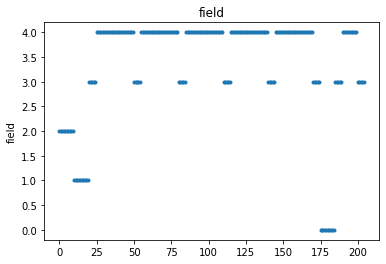

In [8]:
from cngi.vis import visualize

# 1-D plot - let's just see the fields
# this plots field values over the range of data
visualize(vis_xds.field)

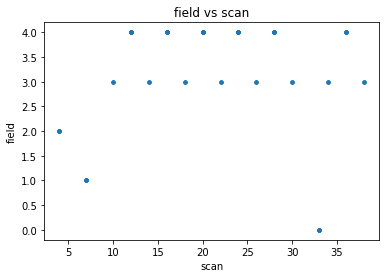

In [9]:
# 2-D plot - fields versus scans
visualize(vis_xds.field, 'scan')

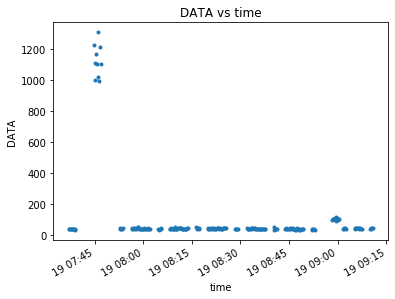

In [10]:
# 2-D plot of 4-D data - DATA over time
# when we specify an x-axis (time), the other axes (baseline, chan, pol) are averaged together
visualize(vis_xds.DATA, 'time')

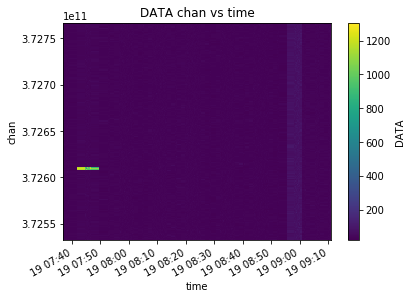

In [11]:
# 3-D plot of 4-D data - DATA over time and channel
# we can give two axes to create a color mesh visualization
visualize(vis_xds.DATA, ['time','chan']) 

# Coordinate Strings

Whenever possible, integer index values from the old MS format have been replaced with the actual string name of the value being indexed. 

This allows selection by either the index position or the actual string name (as shown in the following section).

In [12]:
import numpy as np

# field_id (int) -> field (string)
print(np.unique(vis_xds.field))

['3c279' 'Ceres' 'J0522-364' 'J1037-295' 'TW Hya (5)']


In [13]:
# processor_id -> processor
print(np.unique(vis_xds.processor))

['CORRELATOR (2)']


In [14]:
# observation_id -> observation
print(np.unique(vis_xds.observation))

['uid://A002/X327408/X6f']


In [15]:
# state_id -> state
print(np.unique(vis_xds.state))

['CALIBRATE_AMPLI#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (4)'
 'CALIBRATE_AMPLI#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (5)'
 'CALIBRATE_AMPLI#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (6)'
 'CALIBRATE_AMPLI#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (7)'
 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (0)'
 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (1)'
 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (2)'
 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (3)'
 'CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (8)'
 'CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (9)'
 'OBSERVE_TARGET#ON_SOURCE (10)' 'OBSERVE_TARGET#ON_SOURCE (11)'
 'OBSERVE_TARGET#ON_SOURCE (12)' 'OBSERVE_TARGET#ON_SOURCE (13)'
 'OBSERVE_TARGET#ON_SOURCE (14)' 'OBSERVE_TARGET#ON_SOURCE (15)'
 'OBSERVE_TARGE

# Selection and Splitting

The xarray Dataset format has extensive built-in functions for selecting data and splitting by different criteria.

Rather than cluttering each CNGI function with many parameters for data selection, instead the Dataset should be appropriately split before calling the relevant CNGI API function(s).


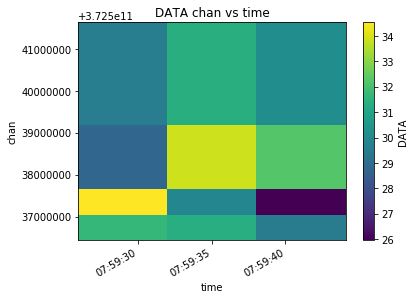

In [16]:
# select by dimension indices
new_xds = vis_xds.isel(time=[76,77,78], chan=[6,7,8,12])

visualize(new_xds.DATA)

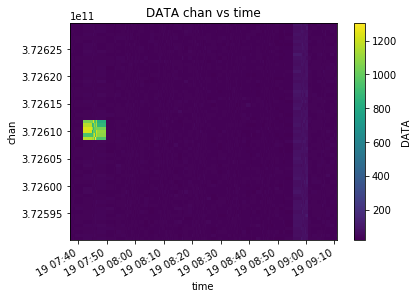

In [17]:
# select by range of dimension values
new_xds = vis_xds.sel(chan=slice(372.59e9, 372.63e9))

visualize(new_xds.DATA)

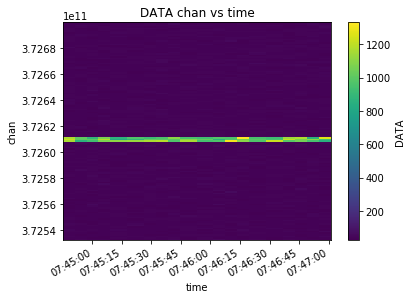

In [18]:
# select by coordinate values
new_xds = vis_xds.where((vis_xds.field == 'Ceres') & (vis_xds.chan < 372.7e9), drop=True)

visualize(new_xds.DATA)

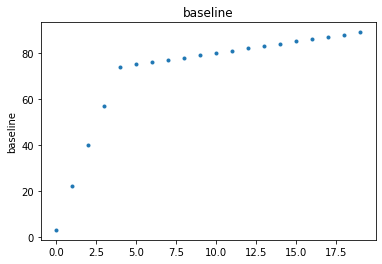

In [25]:
# select by data variable values - find all baselines with antenna 5
new_xds = vis_xds.where((vis_xds.antennas[:,0] == 5) | (vis_xds.antennas[:,1] == 5), drop=True)

visualize(new_xds.baseline)

# Flagging

Any boolean data variable can be used to flag any other data variable of common dimension(s).

Flagged values are set to np.nan, and subsequent math/analysis should be of the type that ignores nan values.

This is a simple operation and does not necessarily require a special function, but one is provided for conveinience.  Here we will show both ways.

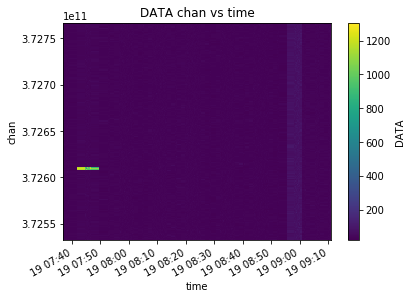

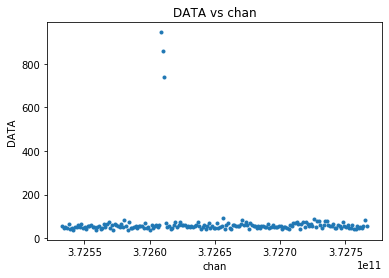

In [26]:
# here is what the raw DATA column looks like
visualize(vis_xds.DATA)

# another way to look at the data, pick a random baseline (34)
visualize(vis_xds.DATA[:,34], 'chan')

/usr/local/lib/python3.6/dist-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


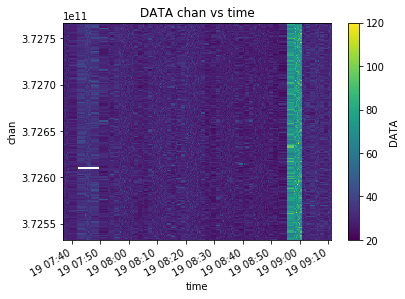

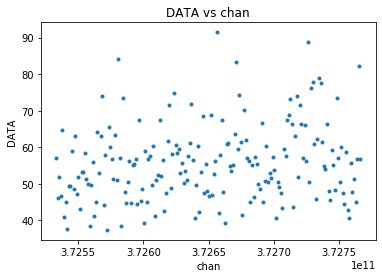

In [27]:
# apply the FLAG and FLAG_ROW data variables
flagged_xds = vis_xds.where((vis_xds.FLAG == 0) & (vis_xds.FLAG_ROW == 0))

# the white line is a set of flagged values (np.nan's)
visualize(flagged_xds.DATA)
visualize(flagged_xds.DATA[:,34], 'chan')

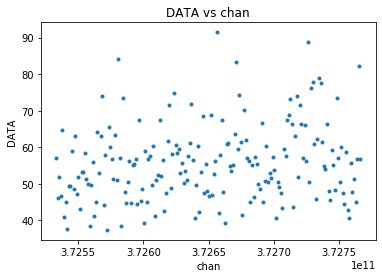

In [28]:
# or with the cngi applyflags function
from cngi.vis import applyflags

flagged_xds = applyflags(vis_xds, flags=['FLAG', 'FLAG_ROW'])

visualize(flagged_xds.DATA[:,34], 'chan')

In [29]:
# one difference is that the applyflags function will remove the flag variables from the return dataset
print(flagged_xds.data_vars)

Data variables:
    ARRAY_ID       (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    DATA           (time, baseline, chan, pol) complex128 dask.array<chunksize=(100, 210, 20, 1), meta=np.ndarray>
    EXPOSURE       (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED1          (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED2          (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    SIGMA          (time, baseline, pol) float64 dask.array<chunksize=(100, 210, 1), meta=np.ndarray>
    TIME_CENTROID  (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    UVW            (time, baseline, uvw_index) float64 dask.array<chunksize=(100, 210, 3), meta=np.ndarray>
    WEIGHT         (time, baseline, pol) float64 dask.array<chunksize=(100, 210, 1), meta=np.ndarray>
